In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

import random

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [2]:
batch_size = 512

fmnist_train = dset.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_test = dset.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [3]:
from sklearn.model_selection import StratifiedKFold
n_split = 5
skf = StratifiedKFold(n_splits = n_split, shuffle = True)

for train_idx, valid_idx in skf.split(np.arange(fmnist_train.__len__()), fmnist_train.targets) : 
    break;

def return_dataloader(train_idx, valid_idx) : 
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    train_data = DataLoader(dataset=fmnist_train, batch_size = batch_size, sampler = train_subsampler)
    valid_data = DataLoader(dataset=fmnist_train, batch_size = batch_size, sampler = valid_subsampler)
    

    dataloaders = {}
    dataloaders['train'] = train_data
    dataloaders['valid'] = valid_data

    return dataloaders
dataloader = return_dataloader(train_idx, valid_idx)

In [4]:
class CVAE(nn.Module) : 
    def __init__(self) : 
        super(CVAE,self).__init__()
        
        self.en_conv1 = nn.Sequential(
                    nn.Conv2d(1, 4, 3 ,padding = 1, bias = False),
                    nn.LayerNorm([4,28,28])
                    )
        self.en_conv2 = nn.Sequential(
                    nn.Conv2d(4, 8, 3, padding = 1, bias = False),
                    nn.LayerNorm([8,28,28])
                    )
                    
        self.fc_mu    = nn.Linear(8*28*28, 256)
        self.fc_sigma = nn.Linear(8*28*28, 256)
        self.de_fc    = nn.Linear(256,8*28*28)

        self.de_conv1 = nn.Sequential(
                    nn.ConvTranspose2d(8, 4, 3, padding = 1, bias = False),
                    nn.LayerNorm([4,28,28])
                    )
        self.de_conv2 = nn.ConvTranspose2d(4, 1, 3, padding = 1, bias = False)

        for m in self.modules() : 
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) : 
                nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d) : 
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def encoder(self,x ) : 
        x = self.en_conv1(x)
        x = self.en_conv2(x)
        x = x.view(-1, 8*28*28)
        mu = self.fc_mu(x)
        sigma = self.fc_sigma(x)
        return mu, sigma

    def reparam(self, mu, sigma) : 
        std = torch.exp(sigma)
        eps = torch.randn_like(std)
        return mu + std *eps
    
    def decoder(self, z) : 
        x = self.de_fc(z)
        x = x.view(-1,8, 28, 28)
        x = self.de_conv1(x)
        x = self.de_conv2(x)
        x = F.sigmoid(x)
        return x / x.max()
    
    def forward(self, x) : 
        mu, sigma = self.encoder(x)
        z = self.reparam(mu, sigma)
        recon = self.decoder(z)
        return recon, mu, sigma


In [5]:
sample = next(iter(dataloader['train']))
sample_x = sample[0][0].to(device)[:,None]
sample_y = sample[1][0]
classes = fmnist_test.classes

In [6]:
def draw_sample(x, recon, y) : 

    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(x).cpu().detach().numpy(), cmap = 'gray')
    plt.title(f'RAW IMAGE OF {classes[y]}')

    plt.subplot(1,2,2)
    plt.imshow(torch.squeeze(recon[0]).cpu().detach().numpy() , cmap = 'gray')
    plt.title(f'REC IMAGE OF {classes[y]}')
    plt.show()

In [7]:
def train_model(model, dataloader, optimizer, num_epoch, early_stop, model_path) : 
    import time

    start_time = time.time()
    early_stop_epoch = 0
    best_val_loss = np.float('inf')

    for epoch in range(num_epoch) : 
        for phase in ['train','valid'] : 
            if phase == 'train' : 
                model.train()
            elif phase == 'valid' : 
                model.eval()
            
            running_loss = 0
            total = 0 


            for x, y in dataloader[phase] : 
                x = x.to(device)
                optimizer.zero_grad()
                total += x.size(0)


                with torch.set_grad_enabled(phase == 'train') : 
                    output, mu, sigma = model(x)
                    bce = F.binary_cross_entropy(output, x, reduction = 'sum').sum(axis = 0)
                    kld = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp()).sum(axis = 0)
                    loss = (kld + bce).mean()
                    
                    if phase == 'train' : 
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()
            
            epoch_loss = running_loss / total

            if phase == 'valid' and epoch_loss < best_val_loss : 
                print(f'On Epoch {epoch}, Best Model Saved with Valid Loss {round(epoch_loss, 6)}')
                
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), model_path)
                early_stop_epoch = 0
                recon = model(sample_x)
                draw_sample(sample_x, recon, sample_y)
        
            elif phase == 'valid' : 
                early_stop_epoch += 1

        if early_stop_epoch >= early_stop : 
            "Early Stop Occured on epoch" + str(epoch)
            break;
    time_elapsed = time.time() - start_time
    print(f'Training Complete in {time_elapsed//60}min {time_elapsed%60}sec')
    print(f'Best Validation Loss : {round(best_val_loss, 6)}')


    model.load_state_dict(torch.load(model_path))
    return model

On Epoch 0, Best Model Saved with Valid Loss 24235.420156


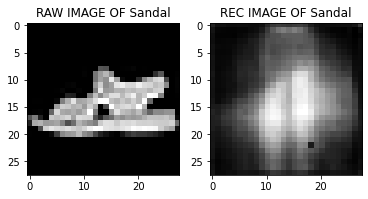

On Epoch 1, Best Model Saved with Valid Loss 5181.131406


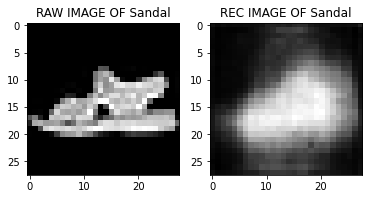

Training Complete in 3.0min 0.19072389602661133sec
Best Validation Loss : 5181.131406


In [8]:
cvae = CVAE().to(device)
optimizer = optim.Adam(cvae.parameters(), lr = 0.005)
trained_cvae = train_model(cvae, dataloader, optimizer, 100, 10, 'cvae.pth')

In [9]:
test_data_lodaer  = DataLoader(dataset = fmnist_test, batch_size  = batch_size , shuffle = False)

In [10]:
with torch.no_grad() : 
    running_loss = 0.0
    for x,_ in test_data_lodaer: 
        x = x.to(device)

        recon, mu, sigma = trained_cvae(x)
        bce = F.binary_cross_entropy(recon, x, reduction = 'none').sum(axis = 1)
        kld = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp()).sum(axis = 0)
        test_loss = (kld + bce).mean()
        running_loss += test_loss.item()

    test_loss = running_loss / len(test_data_lodaer)
    print(test_loss)

20639018.35


torch.Size([272, 28, 28])


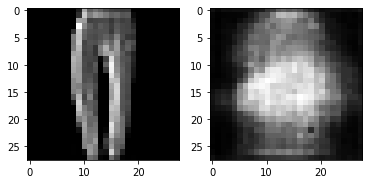

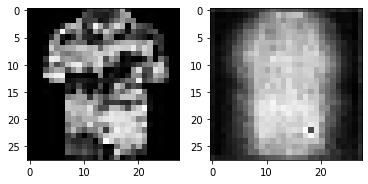

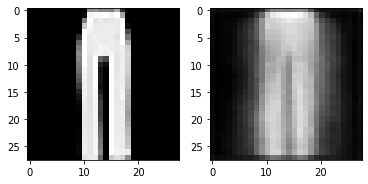

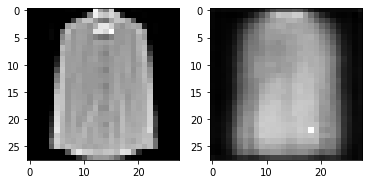

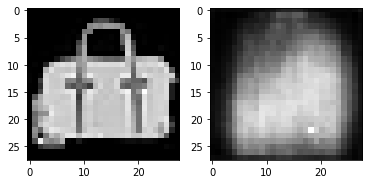

In [11]:
recon_img = torch.squeeze(recon.cpu().data)
print(recon_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(x[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(recon_img[i].numpy().reshape(28, 28),cmap='gray')
    plt.show()